# Noise Spectrum Modeling With Optimization

In this tutorial, we will demonstrate the use of mathematical optimzation for modeling noise spectral density from sensor readout that contain signal that localized at particular frequencies.
Also see [Frequency Series Fitting (with Empirical Mode)](https://kontrol.readthedocs.io/en/latest/tutorials/frequency_series_fitting_with_empirical_model.html) for noise modeling from pure noise measurement.

We will be using a colored noise $n(t)$, which has a power spectral density of

$\hat{N}(f)^2=P_{nn}(f)=\left(\frac{N_{3.5}}{f^{3.5}}\right)^2 + \left(\frac{N_1}{f^1}\right)^2$,

where $N_{3.5}$ and $N_1$ are constants. This kind of noise spectrum resembles the noise of geophone, which has aan amplitude spectral density frequency dependency of $f^{-3.5}$ at lower frequencies and $f^{-1}$ at higher frequencies.

Besides the sensor noise, the sensor readout contains a damped oscillatory signal

$x(t) = A\Re\{e^{\left(\sigma + i\omega_n\right)t}\}$,

where $A$ is a real number, $\sigma$ is a negative real number, and $\omega_n$ is the angular frequency.

Hence, the sensor readout is

$y(t) = x(t) + n(t) = A\Re\{e^{\left(\sigma + i\omega_n\right)t}\} + n(t)$

To simulate real data, we assume a statistical measurement noise drawn uniformly from $\left[-3,3\right]\,\mathrm{dB}$ in the PSD of $y(t)$

To model the noise, we use an amplitude spectral density model

$\hat{N}_\mathrm{model}(f;\theta) = \left[\left(\frac{N_a}{f^a}\right)^2 + \left(\frac{N_b}{f^b}\right)^2\right]^{\frac{1}{2}}$,

where the parameters $\theta=\{N_a, N_b, a, b\}$ or $\theta=\{\log N_a, \log N_b, a, b\}$ (we will compare).

We will fit the noise by minimizing the cost function

$J_\mathrm{noise}(\theta) = \sum_m^M\left[\hat{Y}(f_m) - \hat{N}_\mathrm{model}(f_m;\theta)\right]^2 w(f_m)^2$,

and the log version

$J_\mathrm{noise}(\theta) = \sum_m^M\left[\log\hat{Y}(f_m) - \log\hat{N}_\mathrm{model}(f_m;\theta)\right]^2 w(f_m)^2$

where $f_m$ are frequencies.

Here, $w(f)=0$ at frequencies where the signal $x(t)$ is observable and $w(f)=1$ otherwise.

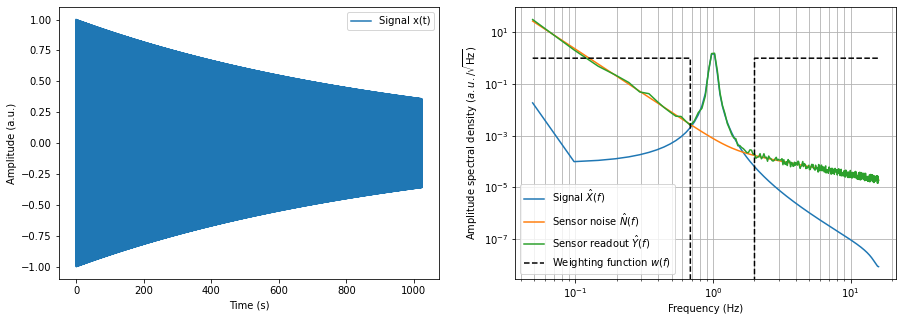

In [1]:
import numpy as np
import control
import scipy.signal
import matplotlib.pyplot as plt


np.random.seed(123)

fs = 32
t = np.arange(0, 2**10, 1/fs)

A = 1
sigma = -0.001
omega_n = 1*2*np.pi
x = A * np.exp((sigma+1j*omega_n) * t).real

# Signal PSD
f, P_xx = scipy.signal.welch(x, fs=fs, nperseg=int(len(t)/50))
mask = f>0
f = f[mask]
P_xx = P_xx[mask]
N_35 = 5e-7**0.5
N_1 = 1e-7**0.5

## Sensor noise PSD
P_nn_true = (N_35/f**3.5)**2 + (N_1/f**1)**2


## Sensor readout with measurement noise
measurement_noise_db = np.random.uniform(-3, 3, len(f))
measurement_noise = 10**(measurement_noise_db/10)
P_yy = (P_xx + P_nn_true) * measurement_noise

## Amplitude spectral densities
ASD_y = P_yy**0.5
ASD_n = P_nn_true**0.5
ASD_x = P_xx**0.5

## Weighing function
w_mask = ~((0.7<f)&(f<2))
w = w_mask.astype(float)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(t, x, label="Signal x(t)")
plt.ylabel("Amplitude (a.u.)")
plt.xlabel("Time (s)")
plt.legend(loc=0)

plt.subplot(122)
plt.loglog(f, ASD_x, label="Signal $\hat{X}(f)$")
plt.loglog(f, ASD_n, label="Sensor noise $\hat{N}(f)$")
plt.loglog(f, ASD_y, label="Sensor readout $\hat{Y}(f)$")
plt.loglog(f, w, "k--", label="Weighting function $w(f)$")
plt.ylabel("Amplitude spectral density $(a.u./\sqrt{\mathrm{Hz}})$")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")
plt.show()

As can be seen from the ASD plot on the right, the signal is clearly dominating at frequencies around 0.7 to 2 Hz.
This give us a hint to set the weighting function

$w(f)=0 ,\ f\in\left[0.7,2\right]\mathrm{Hz}$, and

$w(f)=1 ,\ \textit{otherwise}$

In [2]:
print("$N_{3.5}$: ", N_35)
print("$N_1$: ", N_1)

$N_{3.5}$:  0.0007071067811865475
$N_1$:  0.00031622776601683794


Here, we define two noise models

$\hat{N}_\mathrm{model}(f;N_a, N_b, a, b) = \left[\left(\frac{N_a}{f^a}\right)^2 + \left(\frac{N_b}{f^b}\right)^2\right]^{\frac{1}{2}}$, and

$\hat{N}_\mathrm{model, log}(f;\log N_a, \log N_b, a, b) = \left[\left(\frac{10^{\log N_a}}{f^a}\right)^2 + \left(\frac{10^{\log N_b}}{f^b}\right)^2\right]^{\frac{1}{2}}$,

which are the same but $N_a$ and $N_b$ have different scalings.

The goal now is to fit the models to the measurement $\hat{Y}(f)$ so we obtain

$N_a=N_{3.5}=0.0007071$,

$N_b=N_1=0.0003162$,

$a=3.5$, and

$b=1$

In [3]:
noise_model = lambda f, N_a, N_b, a, b: ((N_a/f**a)**2 + (N_b/f**b)**2)**0.5
noise_model_log_N = lambda f, log_N_a, log_N_b, a, b: noise_model(f, 10**log_N_a, 10**log_N_b, a, b)

In [4]:
# Cost function for least square fit
def J_lsq(theta, f, data, model, weighting_function):
    prediction = model(f, *theta)
    return np.sum((data-prediction)**2 * weighting_function**2)

# Cost function for least square fit that uses log error
def J_lsq_log(theta, f, data, model, weighting_function):
    prediction = model(f, *theta) + np.min(data)*1e-3  # Add a small number so np.log10 won't fail
    return np.sum((np.log10(data)-np.log10(prediction))**2 * weighting_function**2)

In [5]:
import scipy.optimize

# least square fit
result_noise_model_lsq = scipy.optimize.minimize(
    fun=J_lsq, x0=[0, 0, 0, 0], args=(f, ASD_y, noise_model, w))

# least square fit with log error
result_noise_model_lsq_log = scipy.optimize.minimize(
    fun=J_lsq_log, x0=[0, 0, 0, 0], args=(f, ASD_y, noise_model, w))

# least square fit with log parameters
result_noise_model_log_N_lsq = scipy.optimize.minimize(
    fun=J_lsq, x0=[0, 0, 0, 0], args=(f, ASD_y, noise_model_log_N, w))

#least square fit with log error and log parameters
result_noise_model_log_N_lsq_log = scipy.optimize.minimize(
    fun=J_lsq_log, x0=[0, 0, 0, 0], args=(f, ASD_y, noise_model_log_N, w))

# # Alternatively, use kontrol.FrequencySeries
# import kontrol
# import kontrol.core.math
# noise = kontrol.FrequencySeries(f=f, x=ASD_y)
# error_func = kontrol.core.math.log_mse  # mean square log-error
# error_kwargs = {
#     "weight": w
# }
# model = noise_model
# x0 = [0, 0, 0, 0] #initial guess
# optimizer_kwargs = {
#     "options": {"xtol": 1e-6}
# }
# result_kontrol = noise.fit_empirical(
#     model=model, x0=x0, error_func=error_func, error_func_kwargs=error_kwargs, optimizer_kwargs=optimizer_kwargs)
# plt.loglog(f, ASD_n)
# plt.loglog(f, noise.x_empirical)
# plt.show()

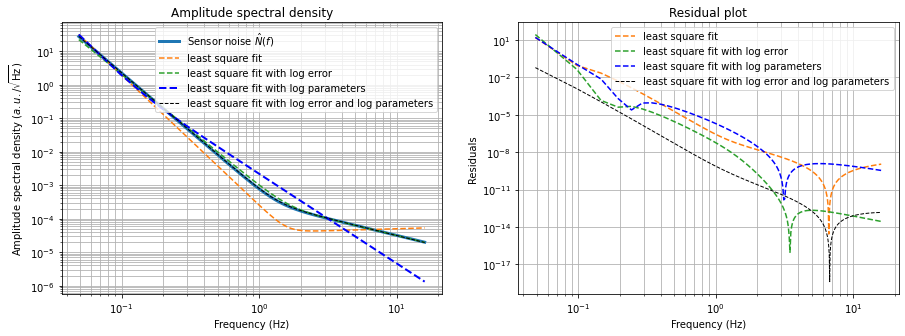

In [6]:
plt.figure(figsize=(15, 5))
plt.subplot(121, title="Amplitude spectral density")
plt.loglog(f, ASD_n, label="Sensor noise $\hat{N}(f)$", lw=3)
plt.loglog(f, noise_model(f, *result_noise_model_lsq.x), "--",
           label="least square fit")
plt.loglog(f, noise_model(f, *result_noise_model_lsq_log.x), "--",
           label="least square fit with log error")
plt.loglog(f, noise_model_log_N(f, *result_noise_model_log_N_lsq.x), "b--",
           label="least square fit with log parameters", lw=2)
plt.loglog(f, noise_model_log_N(f, *result_noise_model_log_N_lsq_log.x), "k--",
           label="least square fit with log error and log parameters", lw=1)
plt.ylabel("Amplitude spectral density $(a.u./\sqrt{\mathrm{Hz}})$")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")

plt.subplot(122, title="Residual plot")
plt.loglog(1,1)
plt.loglog(f, abs(ASD_n-noise_model(f, *result_noise_model_lsq.x))**2, "--",
           label="least square fit")
plt.loglog(f, abs(ASD_n-noise_model(f, *result_noise_model_lsq_log.x))**2, "--",
           label="least square fit with log error")
plt.loglog(f, abs(ASD_n-noise_model_log_N(f, *result_noise_model_log_N_lsq.x))**2, "b--",
           label="least square fit with log parameters")
plt.loglog(f, abs(ASD_n-noise_model_log_N(f, *result_noise_model_log_N_lsq_log.x))**2, "k--",
           label="least square fit with log error and log parameters", lw=1)
plt.ylabel("Residuals")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")
plt.show()

In [7]:
print(result_noise_model_lsq_log.x)

[ 9.65756016e-04 -3.12971942e-04  3.32697339e+00  9.99316484e-01]


In [8]:
a = result_noise_model_log_N_lsq_log.x
print([10**(a[0]), 10**(a[1]), a[2], a[3]])

[0.0007307966833767786, 0.0003301743340508785, 3.4920383253903275, 1.0226320021569824]


As can be seen, least square fit with logarithmic error and log parameters yields much better results, whereas using least square fit directly with or without log parameters both failed visually, using the default parameters.
There're many tweaks in optimization that can be done, for example fine tuning the initial guesses, tolerance, using different optimization algorithms, etc....
But, we won't go into details.

<!-- 
One other thing to note is that the residuals are deceresing with frequency.
This is because the frequency axis is a linearly spaced series, which means that the measurement data clusters at higher frequencies, making the fit bias towards higher frequencies data.
To migitate this, we can resample the data using a log-spaced frequency. -->

In [9]:
# import scipy.interpolate
# f_resample = np.logspace(np.log10(min(f)), np.log10(max(f)), len(f))
# log_ASD_y_interpolate = scipy.interpolate.CubicSpline(x=f, y=np.log10(ASD_y))
# # Or, but it seems CubicSpline works better
# # log_ASD_y_interpolate = scipy.interpolate.interp1d(x=f, y=np.log10(ASD_y), fill_value="extrapolate")
# ASD_y_resample = 10**log_ASD_y_interpolate(f_resample)
# ASD_n_resample = ((N_35/f_resample**3.5)**2 + (N_1/f_resample**1)**2)**0.5
# w_mask_resample = ~((0.7<f_resample)&(f_resample<2))
# w_resample = w_mask_resample.astype(float)

# plt.figure(figsize=(10, 5))
# plt.loglog(f, ASD_y, "o", label="Original readout $\hat{Y}(f)$")
# plt.loglog(f_resample, ASD_y_resample, ".", markersize=2, label="Resampled $\hat{Y}(f)$ with logspace frequency")
# plt.loglog(f_resample, w_resample, ".", markersize=2, label="Resampled weighing function $w(f)$")
# plt.ylabel("Amplitude spectral density $(a.u./\sqrt{\mathrm{Hz}})$")
# plt.xlabel("Frequency (Hz)")
# plt.legend(loc=0)
# plt.grid(which="both")

In [10]:
# result_noise_model_lsq_log_resampled = scipy.optimize.minimize(fun=J_lsq_log, x0=[0,0,0,0], args=(f_resample, ASD_y_resample, noise_model, w_resample))
# result_noise_model_log_N_lsq_log_resampled = scipy.optimize.minimize(fun=J_lsq_log, x0=[0,0,0,0], args=(f_resample, ASD_y_resample, noise_model_log_N, w_resample))

In [11]:
# plt.figure(figsize=(15, 5))
# plt.subplot(121, title="Amplitude spectral density")
# plt.loglog(f, ASD_n, label="Sensor noise $\hat{N}(f)$", lw=3)
# # plt.loglog(f_resample, ASD_n_resample, label="Re Sensor noise $\hat{N}(f)$", lw=3)

# # plt.loglog(f, noise_model(f, *result_noise_model_lsq.x), "--", label="least square fit")
# plt.loglog(f, noise_model(f, *result_noise_model_lsq_log.x), "--", label="least square fit with log error")
# plt.loglog(f, noise_model(f, *result_noise_model_lsq_log_resampled.x), "--", label="least square fit with log error with resampled logspace data")
# # plt.loglog(f, noise_model_log_N(f, *result_noise_model_log_N_lsq.x), "b--", label="least square fit with log parameters", lw=2)
# # plt.loglog(f_resample, noise_model_log_N(f_resample, *result_noise_model_log_N_lsq_log_resampled.x), "k--", label="least square fit with log error and log parameters", lw=1)
# plt.ylabel("Amplitude spectral density $(a.u./\sqrt{\mathrm{Hz}})$")
# plt.xlabel("Frequency (Hz)")
# plt.legend(loc=0)
# plt.grid(which="both")

# plt.subplot(122, title="Residual plot")
# plt.loglog(1,1)
# # plt.loglog(f, abs(ASD_n-noise_model(f, *result_noise_model_lsq.x))**2, "--", label="least square fit")
# plt.loglog(f, abs(ASD_n-noise_model(f, *result_noise_model_lsq_log.x))**2, "--", label="least square fit with log error")
# plt.loglog(f_resample, abs(ASD_n_resample-noise_model(f_resample, *result_noise_model_lsq_log_resampled.x))**2, "--", label="least square fit with log error with resampled logspace data")
# # plt.loglog(f, abs(ASD_n-noise_model_log_N(f, *result_noise_model_log_N_lsq.x))**2, "b--", label="least square fit with log parameters")
# plt.loglog(f, abs(ASD_n-noise_model_log_N(f, *result_noise_model_log_N_lsq_log.x))**2, "b--", label="least square fit with log error and log parameters", lw=1)
# plt.loglog(f, abs(ASD_n-noise_model_log_N(f, *result_noise_model_log_N_lsq_log_resampled.x))**2, "k--", label="Resampled least square fit with log error and log parameters", lw=1)
# plt.ylabel("Residuals")
# plt.xlabel("Frequency (Hz)")
# plt.legend(loc=0)
# plt.grid(which="both")
# plt.show()